<a href="https://colab.research.google.com/github/kanishkapg/potato_leaf_disease/blob/main/Potato_Leaf_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import tensorflow as tf
print(tf.__version__)


2.18.0


In [6]:
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20

In [9]:
df = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/ML datasets/PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2192 files belonging to 3 classes.


In [10]:
class_names = df.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [11]:
len(df)

69

In [12]:
for image_batch, labels_batch in df.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 1 1 0 0 0 1 0 2 0 1 1 0 0 0 1 1 0 1 1 0 0 1 2 1 0 0 0 0]


In [13]:
for image_batch, labels_batch in df.take(1):
    print(image_batch[0].numpy())

[[[154. 153. 161.]
  [133. 132. 140.]
  [153. 152. 160.]
  ...
  [171. 169. 183.]
  [163. 161. 175.]
  [173. 171. 185.]]

 [[149. 148. 156.]
  [136. 135. 143.]
  [146. 145. 153.]
  ...
  [180. 178. 192.]
  [178. 176. 190.]
  [189. 187. 201.]]

 [[133. 132. 140.]
  [144. 143. 151.]
  [158. 157. 165.]
  ...
  [176. 174. 187.]
  [180. 178. 191.]
  [192. 190. 203.]]

 ...

 [[122. 120. 131.]
  [122. 120. 131.]
  [124. 122. 133.]
  ...
  [161. 163. 176.]
  [162. 164. 177.]
  [150. 152. 165.]]

 [[165. 163. 174.]
  [154. 152. 163.]
  [138. 136. 147.]
  ...
  [134. 136. 149.]
  [137. 139. 152.]
  [135. 137. 150.]]

 [[121. 119. 130.]
  [132. 130. 141.]
  [142. 140. 151.]
  ...
  [153. 155. 168.]
  [157. 159. 172.]
  [161. 163. 176.]]]


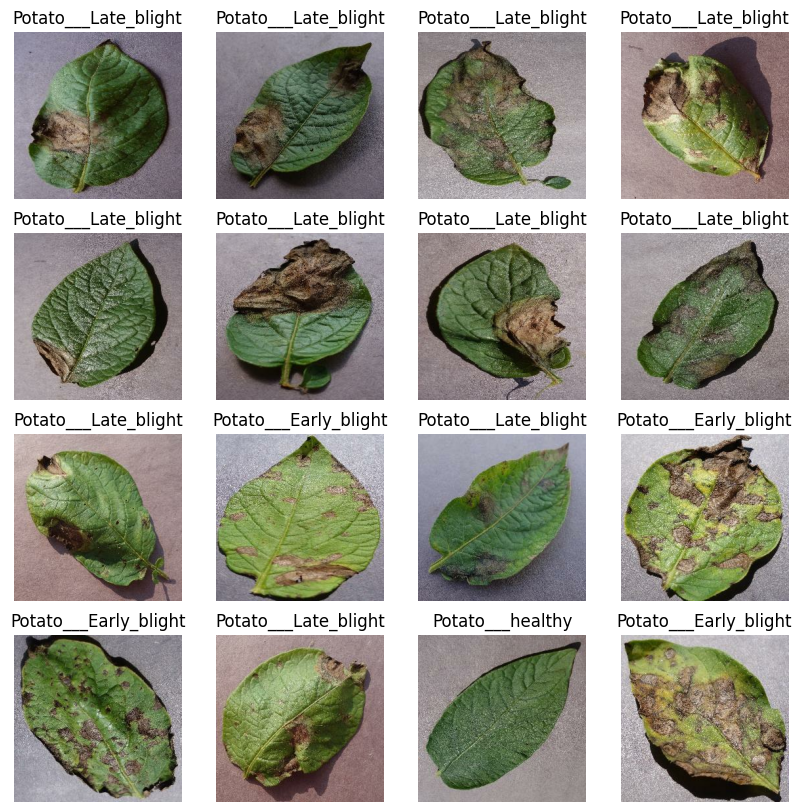

In [14]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in df.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")

### **Splitting the Dataset**
*   train_set = 80%
*   validation_set = 10%
*   test_set = 10%



In [15]:
def get_dataset_partitions(df, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=10000):
    df_size = len(df)

    if shuffle:
        df = df.shuffle(shuffle, seed=12)

    train_size = int(df_size * train_split)
    val_size = int(df_size * val_split)

    train_df = df.take(train_size)
    val_df = df.skip(train_size).take(val_size)
    test_df = df.skip(train_size).skip(val_size)

    return train_df, val_df, test_df


In [16]:
train_df, val_df, test_df = get_dataset_partitions(df)

In [17]:
len(train_df)

55

In [18]:
train_df = train_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_df = val_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_df = test_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

**Data Augmentation**

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

In [22]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation="relu", input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax"),

])

model.build(input_shape=input_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [26]:
model.fit(
    train_df,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_df
)

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 268s 5s/step - accuracy: 0.5454 - loss: 0.8287 - val_accuracy: 0.5729 - val_loss: 0.7376
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 242s 4s/step - accuracy: 0.7034 - loss: 0.6734 - val_accuracy: 0.6354 - val_loss: 0.7064
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 245s 4s/step - accuracy: 0.8099 - loss: 0.4448 - val_accuracy: 0.8073 - val_loss: 0.3983
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 248s 5s/step - accuracy: 0.8277 - loss: 0.4141 - val_accuracy: 0.9010 - val_loss: 0.2927
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 245s 4s/step - accuracy: 0.8335 - loss: 0.4505 - val_accuracy: 0.9323 - val_loss: 0.2538
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 250s 5s/step - accuracy: 0.9033 - loss: 0.2411 - val_accuracy: 0.8958 - val_loss: 0.2718
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 244s 4s/step - accuracy: 0.9343 - loss: 0.1553 - val_accuracy: 0.9010 - val_loss: 0.2252
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 244s 4s/step - accuracy: 0.9345 - loss: 0.1686 - val_accuracy: 0.7500 - v

In [29]:
scores = model.evaluate(test_df)

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 984ms/step - accuracy: 0.9686 - loss: 0.0867


First Image
Actual Label:  Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Label Potato___Early_blight


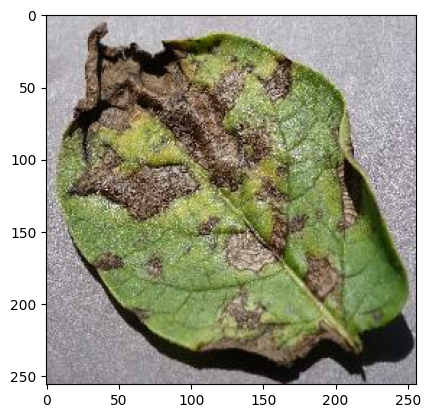

In [33]:
import numpy as np
for image_batch, labels_batch in test_df.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First Image")
    plt.imshow(first_image)
    print("Actual Label: ", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("Predicted Label", class_names[np.argmax(batch_prediction[0])])

In [37]:
def predict(model, img):
    img_arr = tf.keras.preprocessing.image.img_to_array(img)
    img_arr = tf.expand_dims(img_arr, 0)

    predictions = model.predict(img_arr)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)

    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


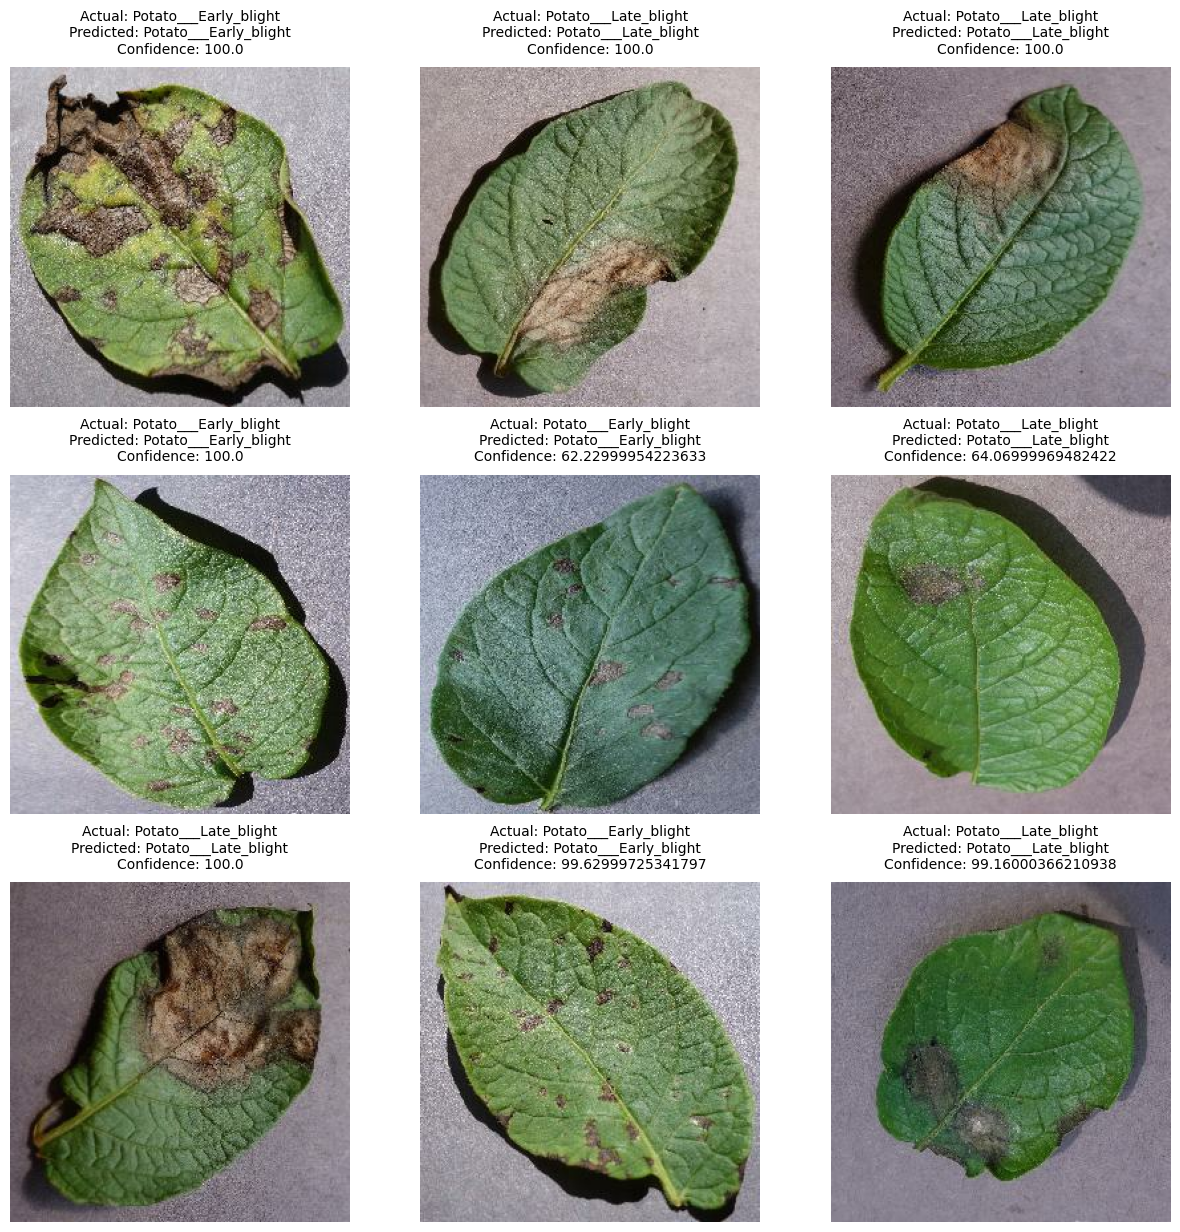

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in test_df.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}",
                  fontsize=10, pad=10)

        plt.axis("off")